In [ ]:
%reload_ext autoreload
%autoreload 2

import os
from datetime import datetime, timedelta
from plotnine import *

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import pandas as pd
from dateutil.parser import parse
from pytz import UTC, timezone
from mizani.formatters import date_format

from watttime import (
    WattTimeOptimizer,
    RecalculatingWattTimeOptimizer, 
)

from evaluation import eval_framework as efu

In [2]:
def plot_schedule(schedule):
    plot_dat = schedule.melt(id_vars = "point_time", value_vars=["pred_moer", "usage"])
    return (ggplot(plot_dat, aes(x = "point_time", y = "value")) +
    geom_line(size = 1.5) + 
    facet_wrap("~variable", scales = "free_y", nrow = 2) + 
    theme_bw(base_size = 20) + 
    theme(figure_size=(12, 8)) +
    scale_x_datetime(labels = date_format("%Y-%m-%d %H:%M:%S")) +
    labs(x = "Time", y = "Usage kWh                    Predicted MOER"))

In [3]:
region = "SPP_TX"
username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [4]:
start_time = datetime(2023, 7, 11, 20, 6)
start_time = UTC.localize(start_time)

In [5]:
wt_opt = WattTimeOptimizer(username, password)

window_start_test = start_time
window_end_test = window_start_test + timedelta(hours = 24)
usage_power_kw = 12
moer_data = efu.get_historical_fcst_data(window_start_test, 12*12, region)

basic_usage_plan = wt_opt.get_optimal_usage_plan(
    region=region,
    usage_window_start=window_start_test,
    usage_window_end=window_end_test,
    usage_time_required_minutes=240,
    usage_power_kw=usage_power_kw,
    optimization_method="baseline",
    moer_data_override= moer_data
)

simple_usage_plan = wt_opt.get_optimal_usage_plan(
    region=region,
    usage_window_start=window_start_test,
    usage_window_end=window_end_test,
    usage_time_required_minutes=240,
    usage_power_kw=usage_power_kw,
    optimization_method="simple",
    moer_data_override= moer_data
)


basic_usage_plan = basic_usage_plan.reset_index()
simple_usage_plan = simple_usage_plan.reset_index()

== Baseline fit! ==
== Simple fit! ==


# Why Requerying is Desirable:

Our goal is to improve on the 'baseline' (i.e., ASAP) power use plan to reduce emissions. We do so with a forecast of what the marginal emissions are likely to be in the relevant region over the relevant time period. 

The figure below shows this 'baseline' plan and a forecast of the MOER in SPP Texas for a 12 hour period during the summer of 2023. The baseline plan consumes power during some high-MOER periods, causing more emissions.

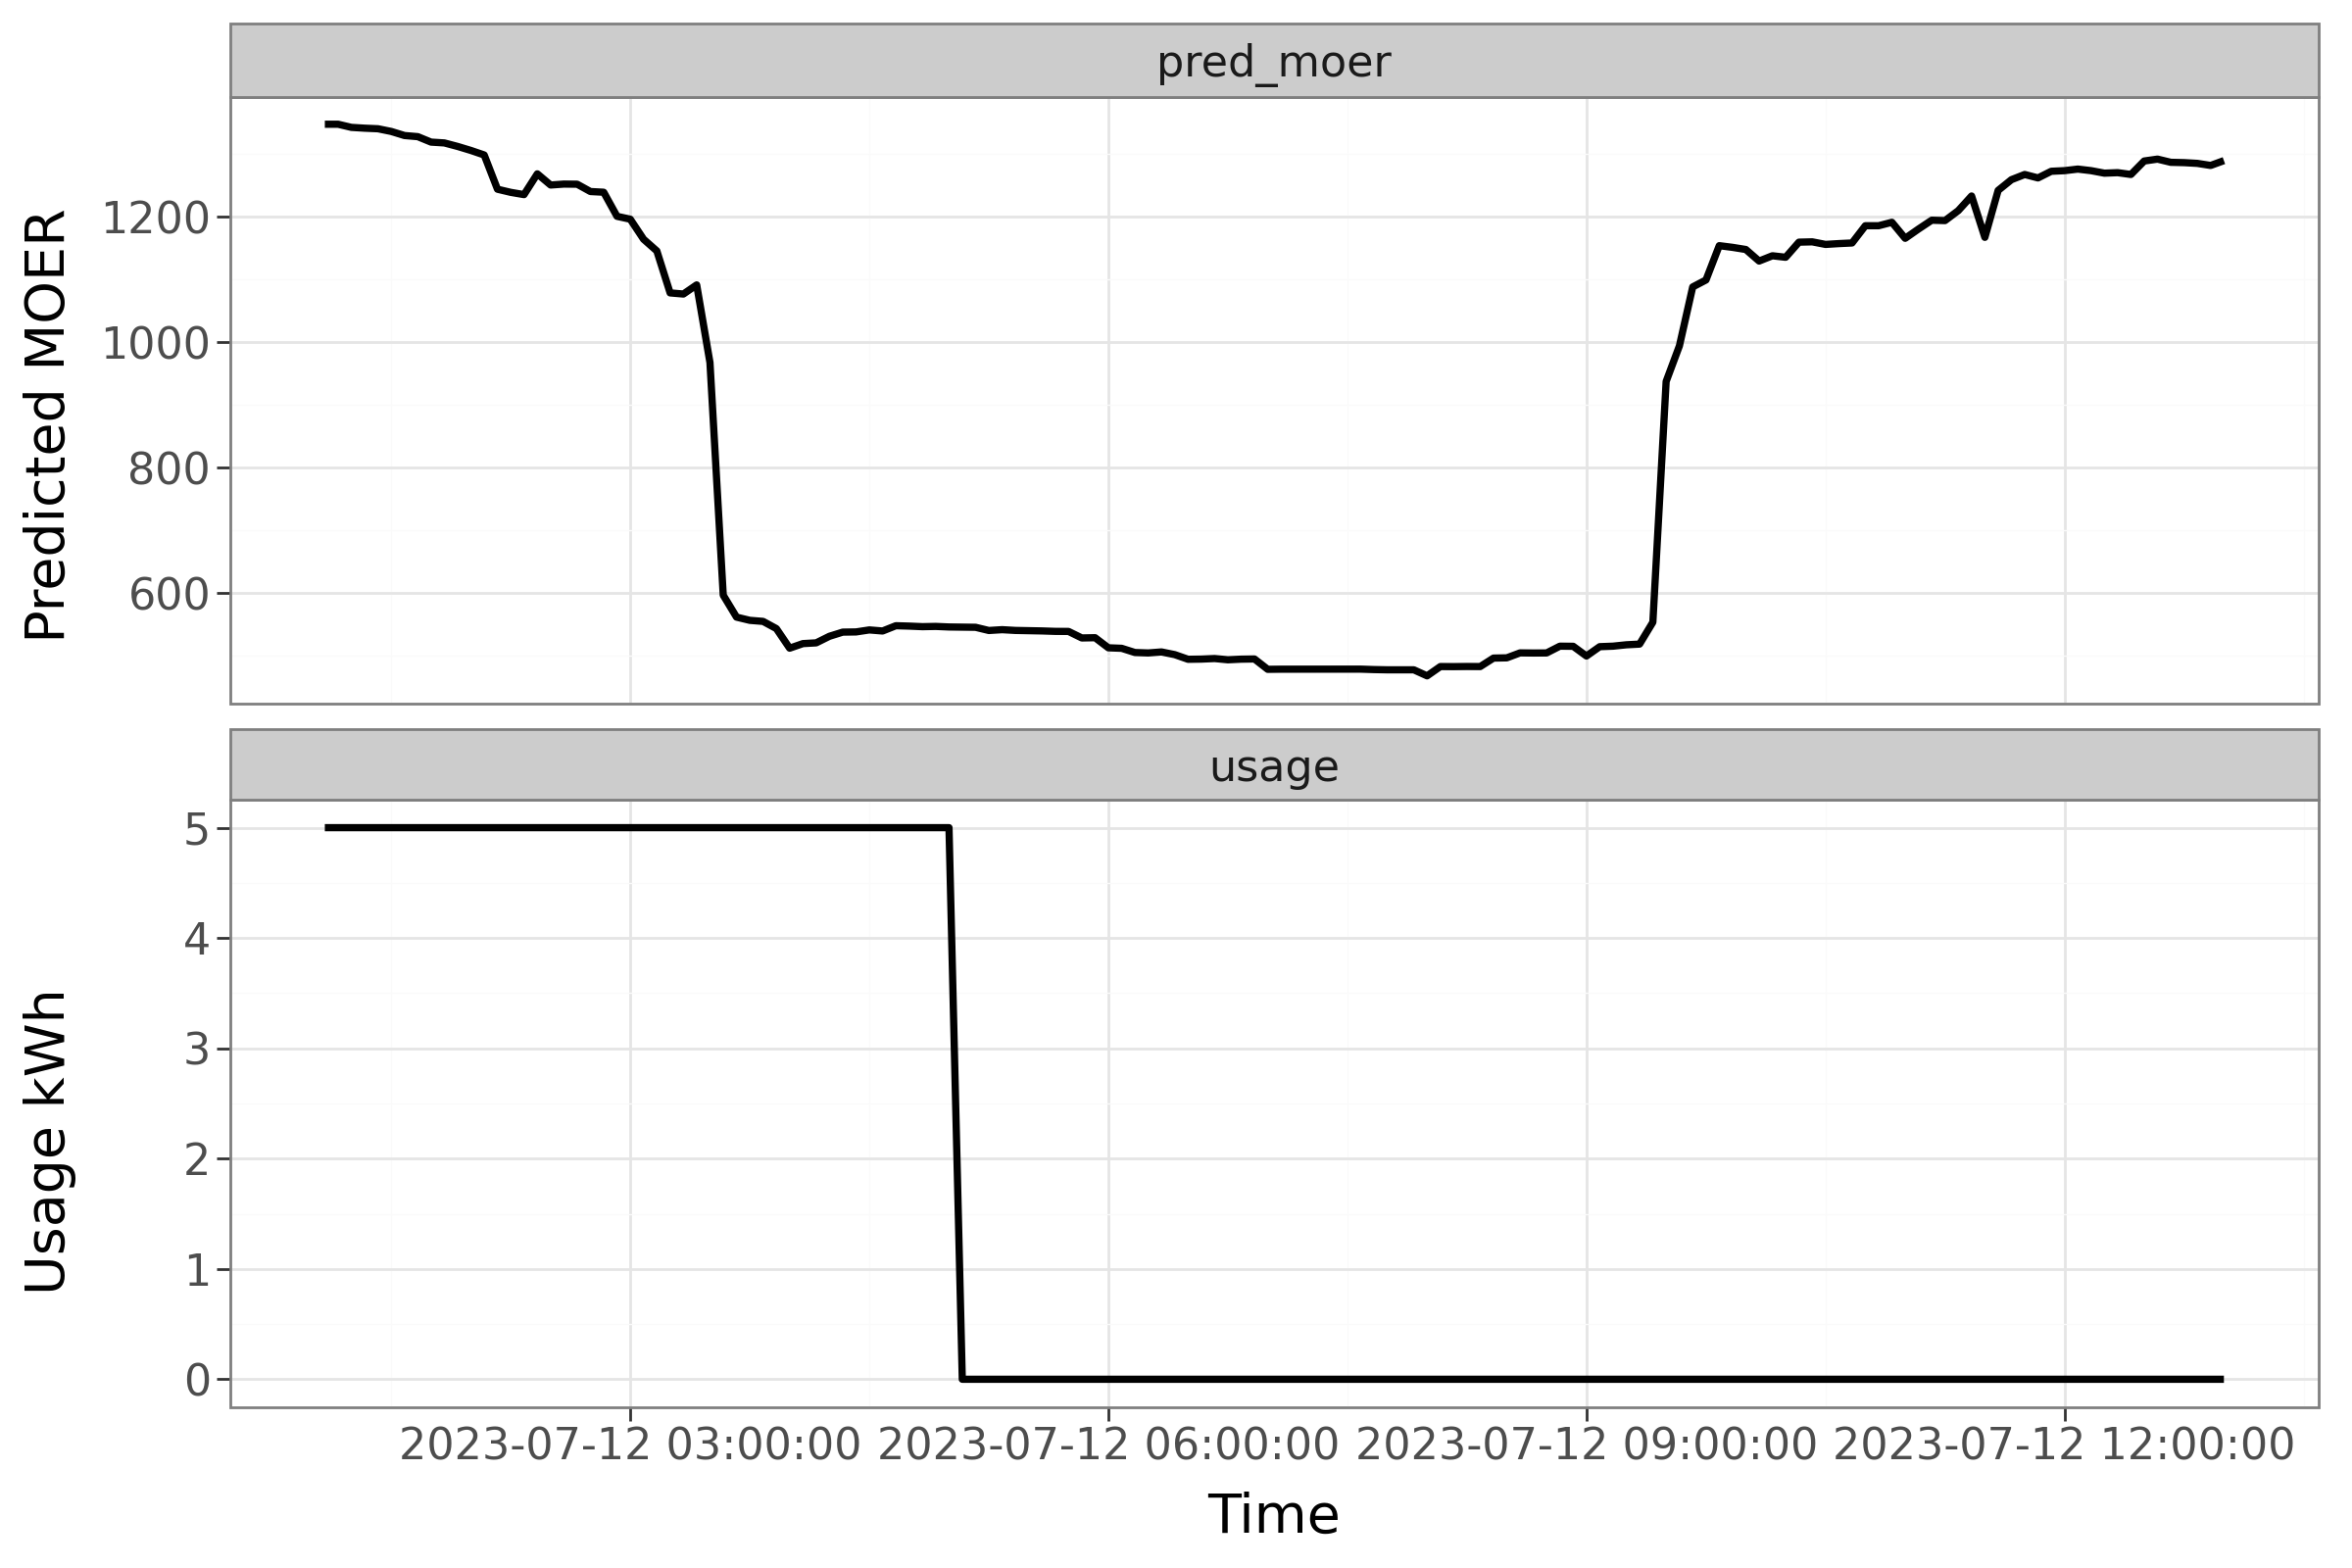

In [6]:
plot_schedule(basic_usage_plan)

Below, we show the 'simple' optimization over the same period. Here we charge only during the lowest MOER periods:

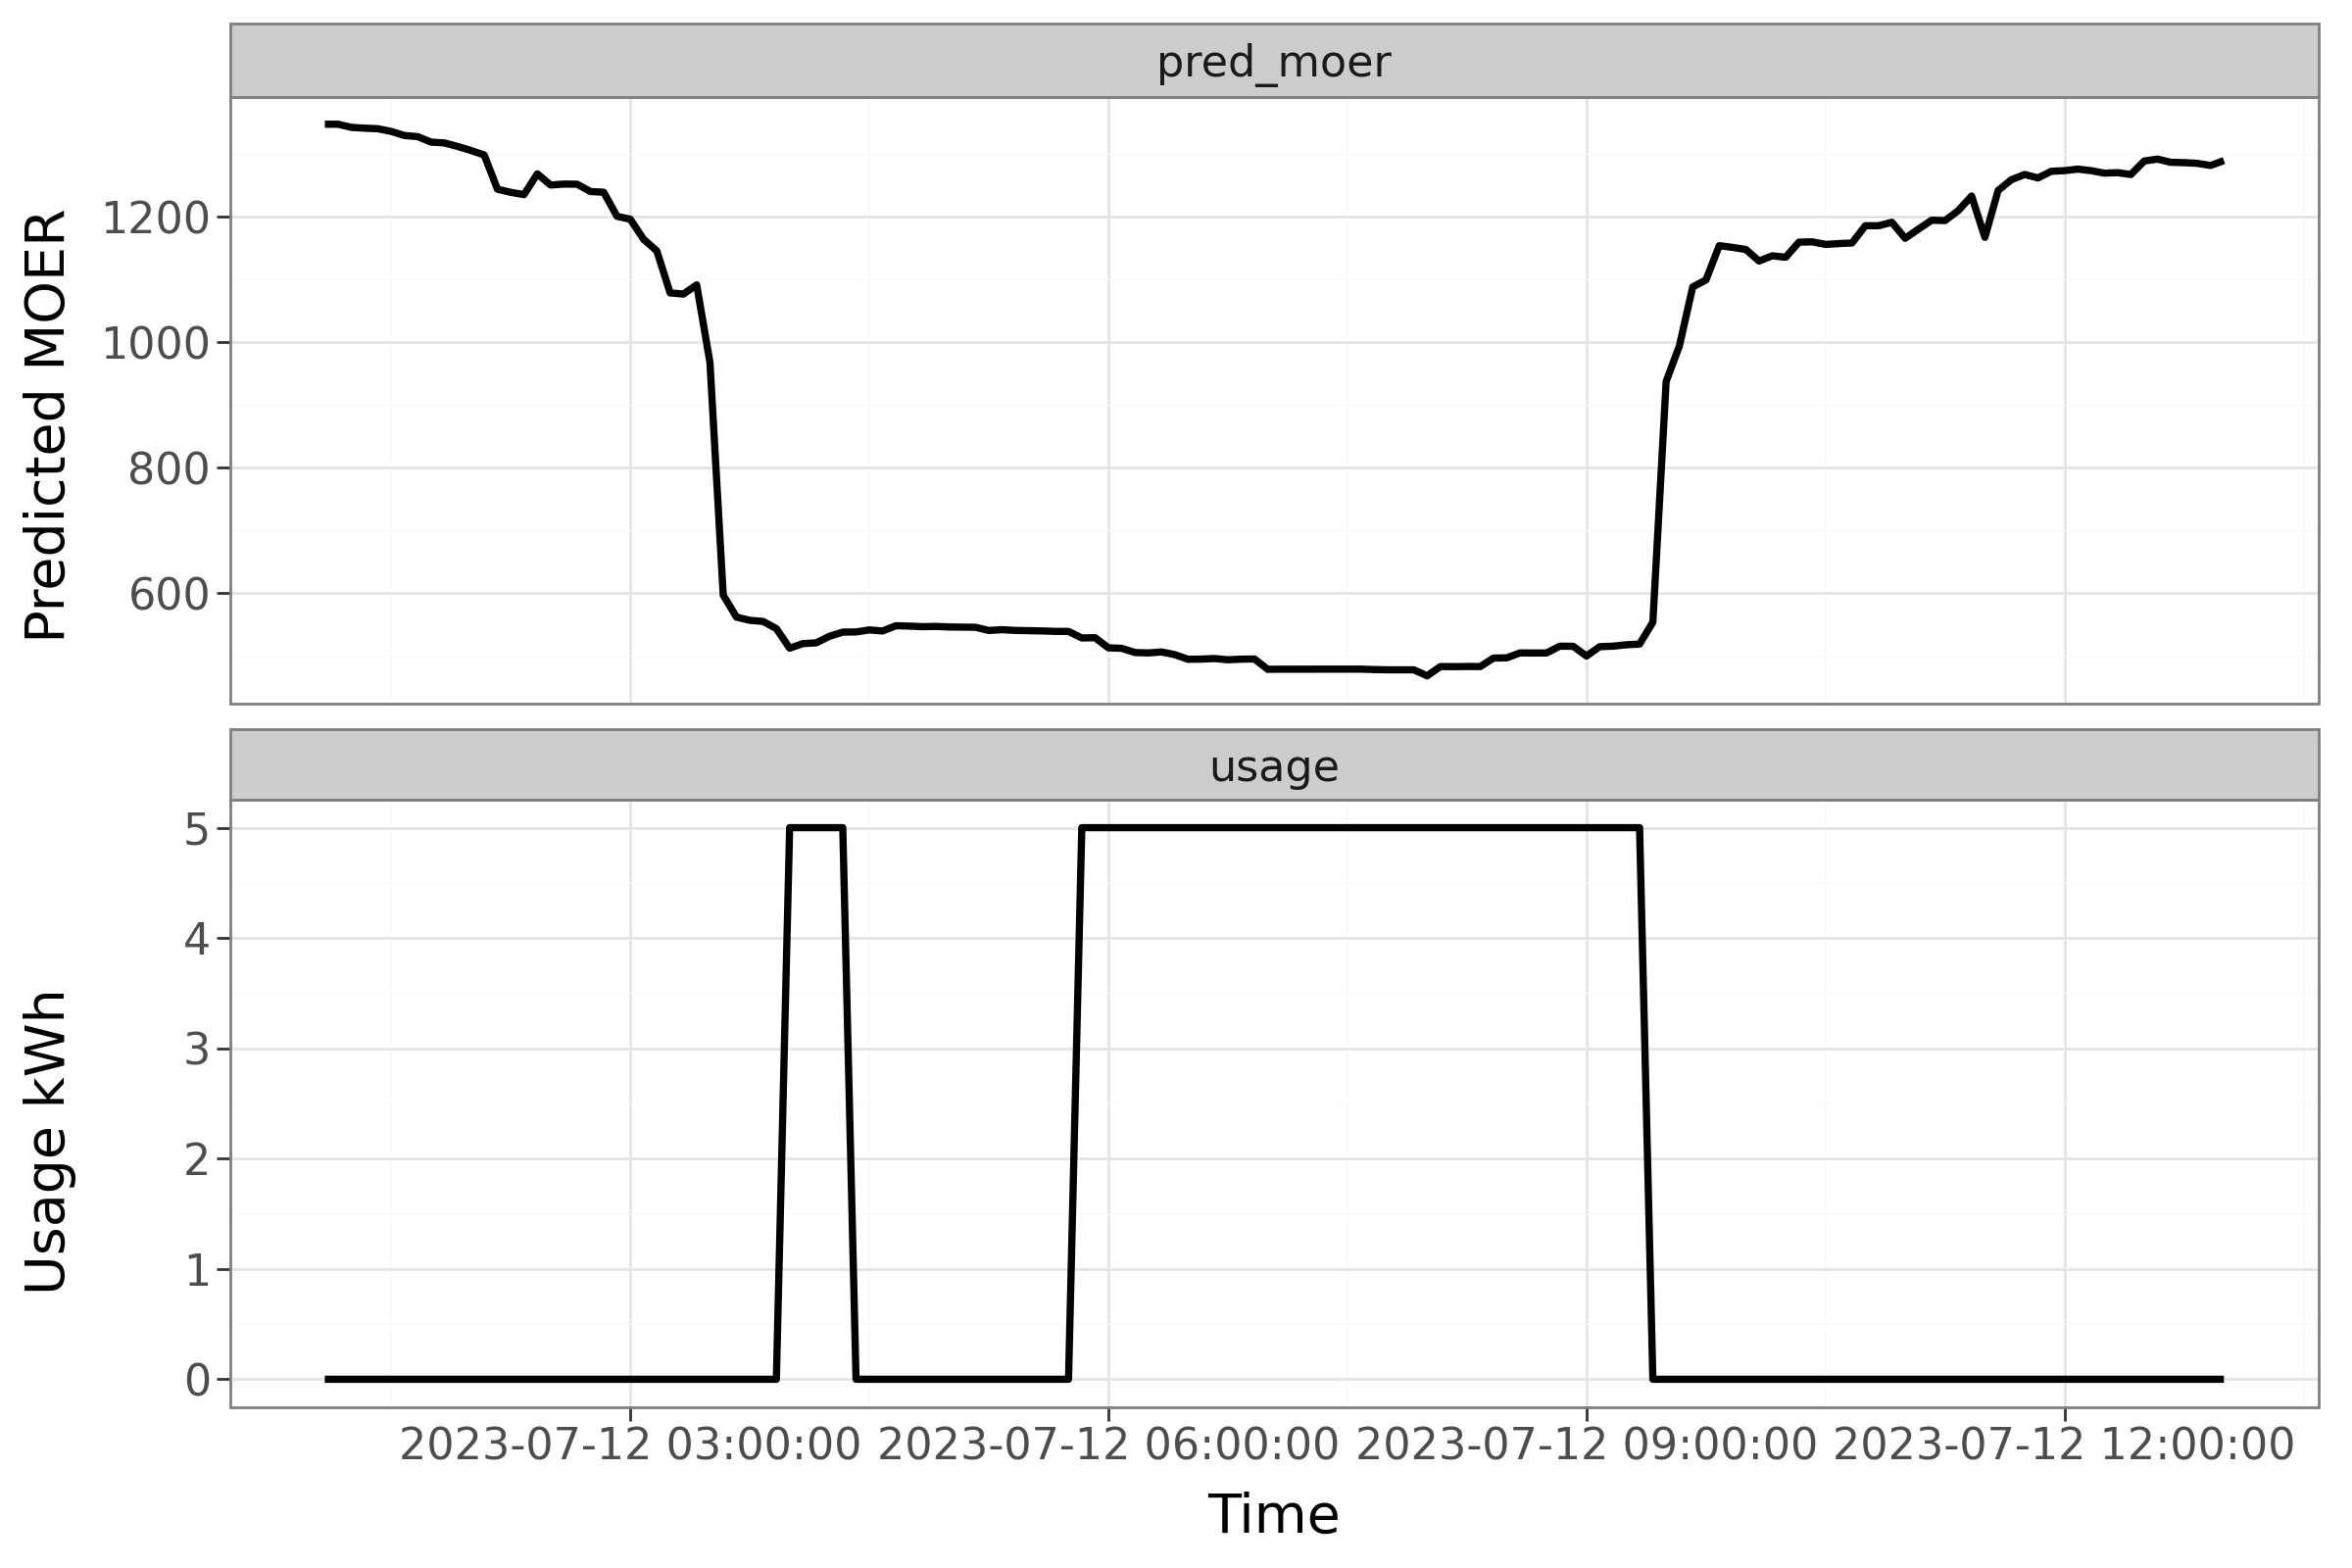

In [7]:
plot_schedule(simple_usage_plan)

However, our optimization is only as good as the forecast. In some cases, particularly in regions where hard-to-predict forms of energy generation like wind are common, the forecast may diverge from what actually happens. Below we show the true historical MOER for SPP Texas during this period and plot the 'ideal' simple optimization. Notice that the two simple schedules are very different - some of the times that were forecasted to be high emissions turned out to be low emissions, and some which were supposed to be cleaner turned out to be dirty. 

In [8]:
actuals = efu.get_historical_actual_data(window_start_test, 12*12, region)

simple_usage_plan_actual = wt_opt.get_optimal_usage_plan(
    region=region,
    usage_window_start=window_start_test,
    usage_window_end=window_end_test,
    usage_time_required_minutes=240,
    usage_power_kw=usage_power_kw,
    optimization_method="simple",
    moer_data_override= actuals
)

== Simple fit! ==


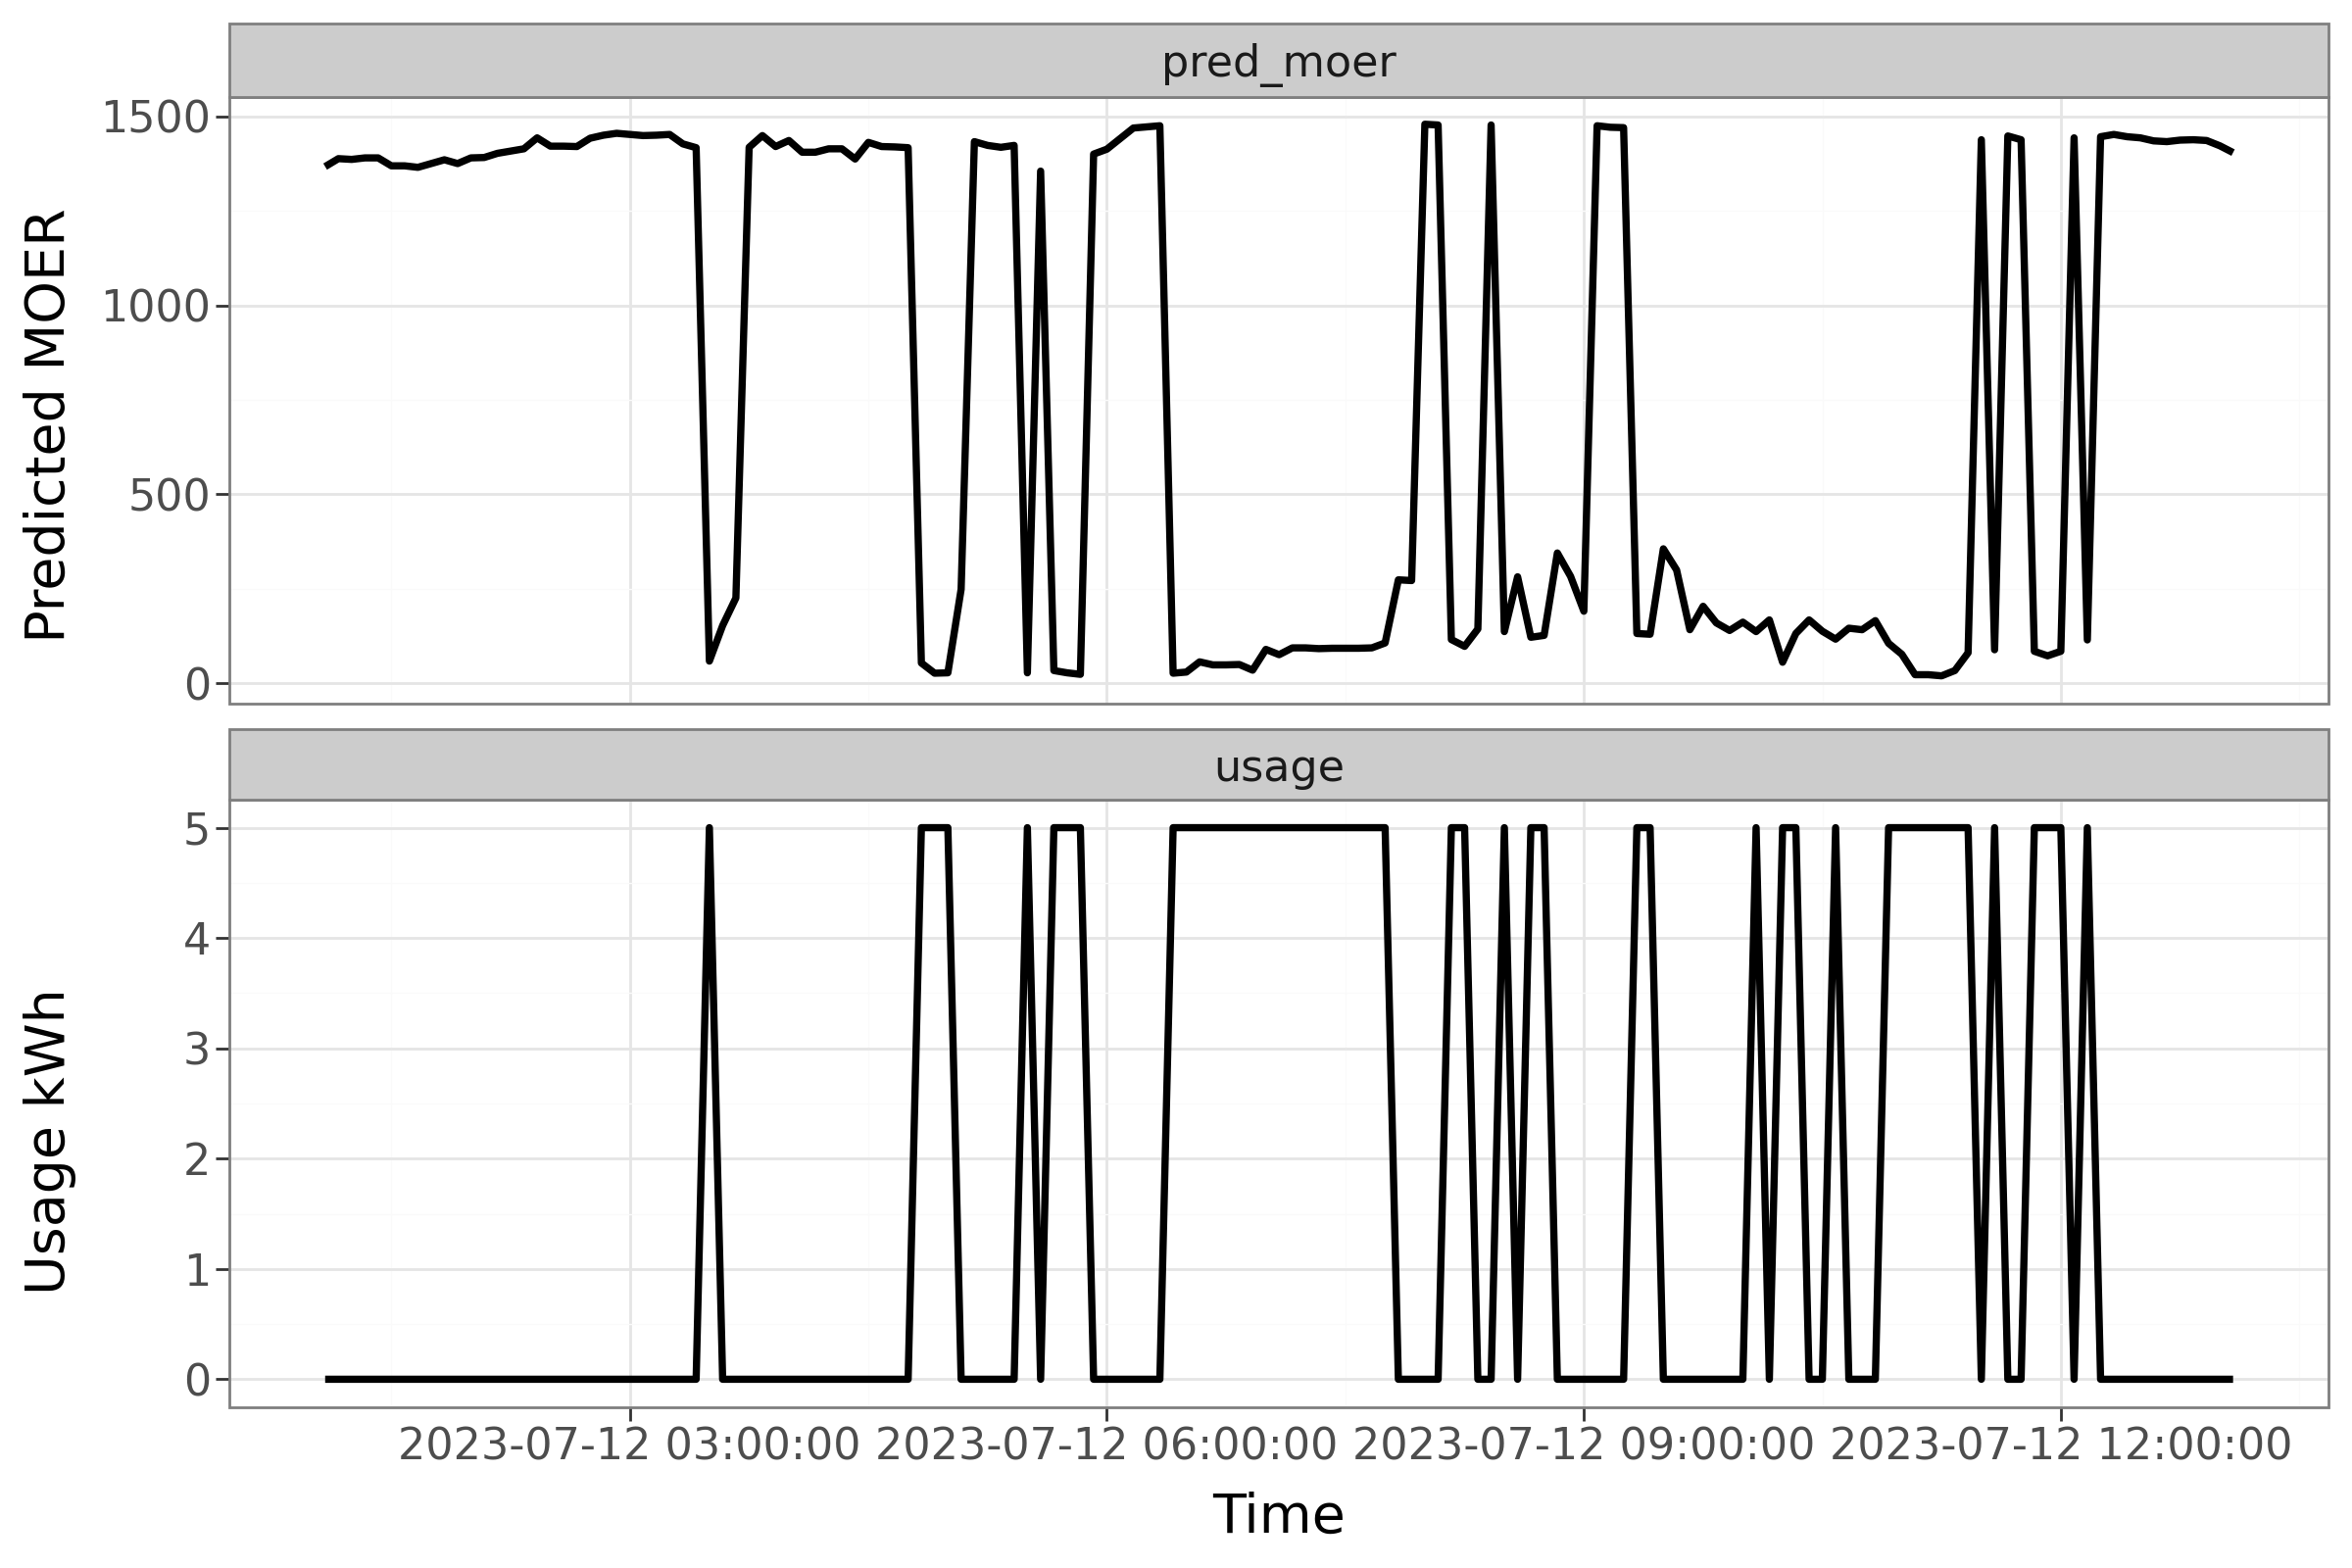

In [9]:
plot_schedule(simple_usage_plan_actual.reset_index())

One way to address this challenge is to 'refresh' our schedule by periodically retreiving and up-to-date version of the relevant forecast. This is implemented with the `RecalculatingWattTimeOptimizer` class and the method `get_new_schedule` which allows the user to update the schedule using the new forecast. This approach assumes that the original schedule is followed until the point at which the new schedule is generated, at which point the new schedule is followed until another update is made. 

In [13]:
recalculating_optimizer_start_time = start_time + timedelta(hours=5)
recalculating_optimizer_end_time = recalculating_optimizer_start_time + timedelta(hours=12)

recalculating_optimizer = RecalculatingWattTimeOptimizer(
    region=region, 
    watttime_username=username, 
    watttime_password=password, 
    usage_time_required_minutes=240,
    usage_power_kw=2,
    optimization_method="simple"
)

schedules = []
costs = []
pred_costs = []
forecasts = []


x = 0
while x < 12:
    new_recalculating_optimizer_start_time = recalculating_optimizer_start_time + timedelta(hours = x)

    recalculating_optimizer.get_new_schedule(
        new_recalculating_optimizer_start_time, 
        recalculating_optimizer_end_time
    )

    fcst = efu.get_historical_fcst_data(new_recalculating_optimizer_start_time, (12 - x) * 12, region=region)
    fcst["made_at"] = x
    forecasts.append(fcst)

    sch = recalculating_optimizer.get_combined_schedule().reset_index()
    sch["made_at"] = x

    schedules.append(sch)
    #costs.append(recalculating_optimizer.get_actual_combined_schedule_cost())
    #pred_costs.append(recalculating_optimizer.get_actual_combined_schedule_cost)

    x += 1

== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==
== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


== Simple fit! ==


In [28]:
all_forecasts = pd.concat(forecasts)
all_forecasts["point_time"] = pd.to_datetime(all_forecasts["point_time"])

Our schedule from the first hour is identical to the previous simple schedule:

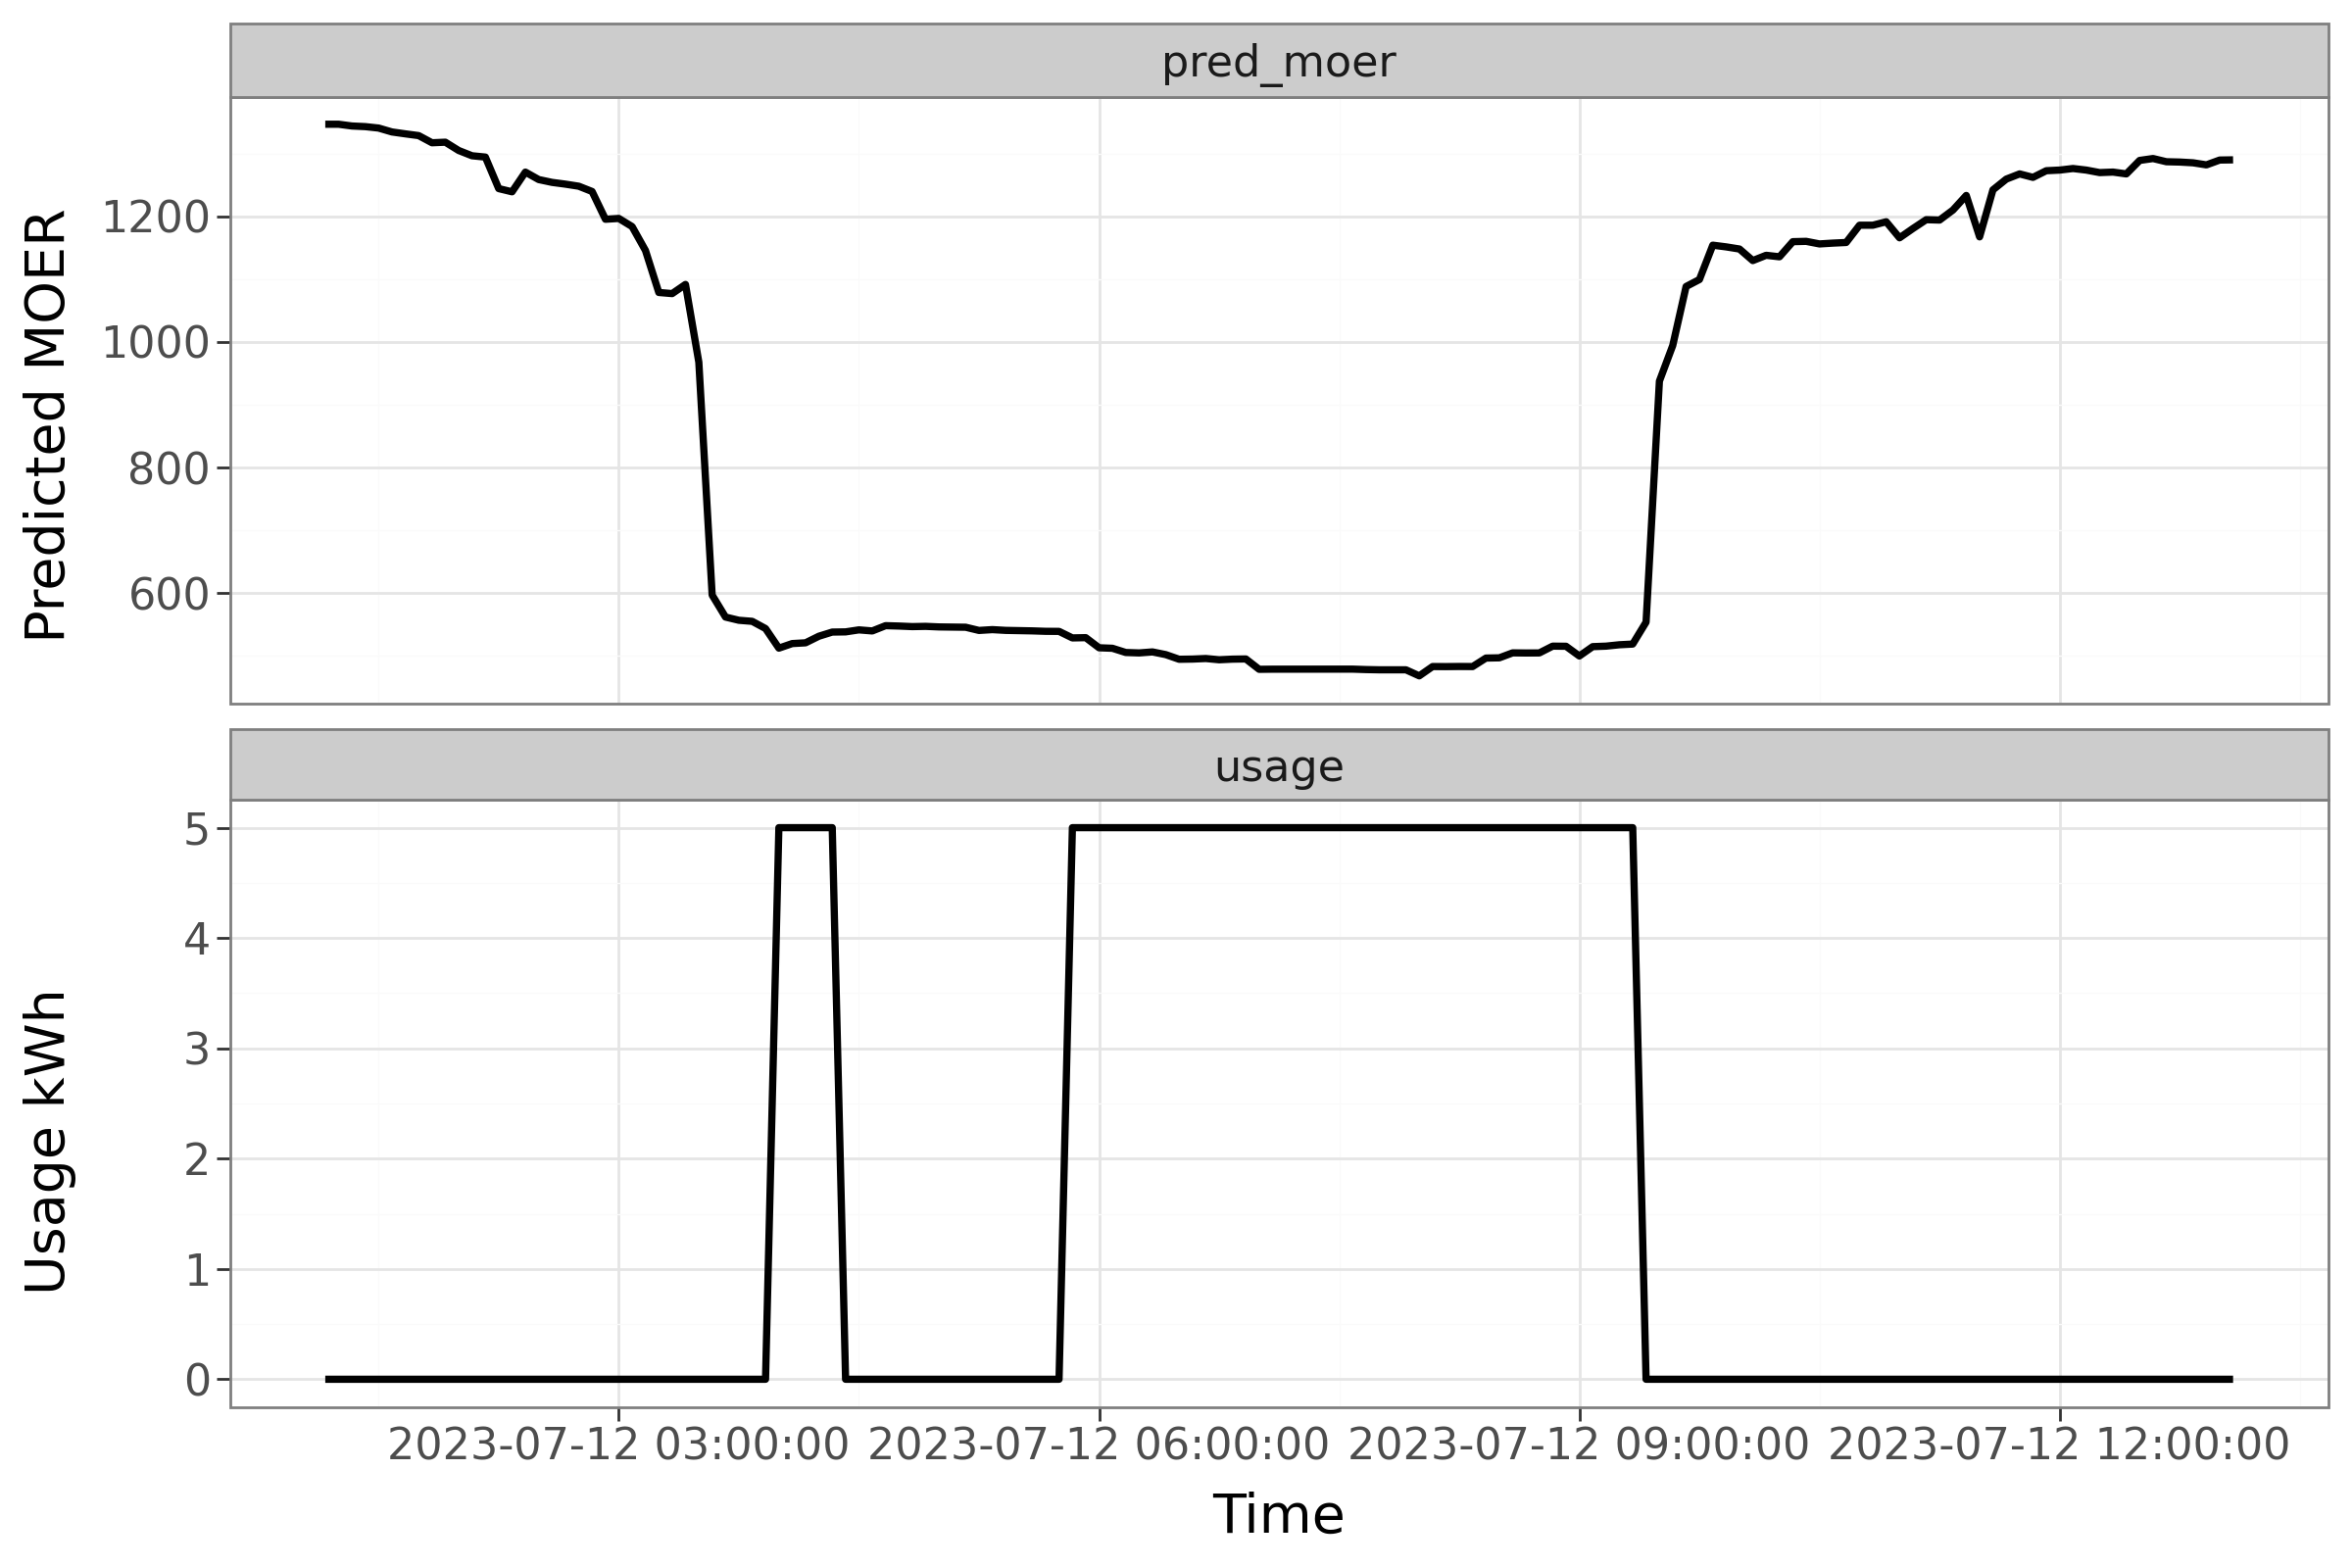

In [39]:
plot_schedule(schedules[0])

However, the actual schedule used (the schedule from the final update) looks much more like the ideal schedule, because the 

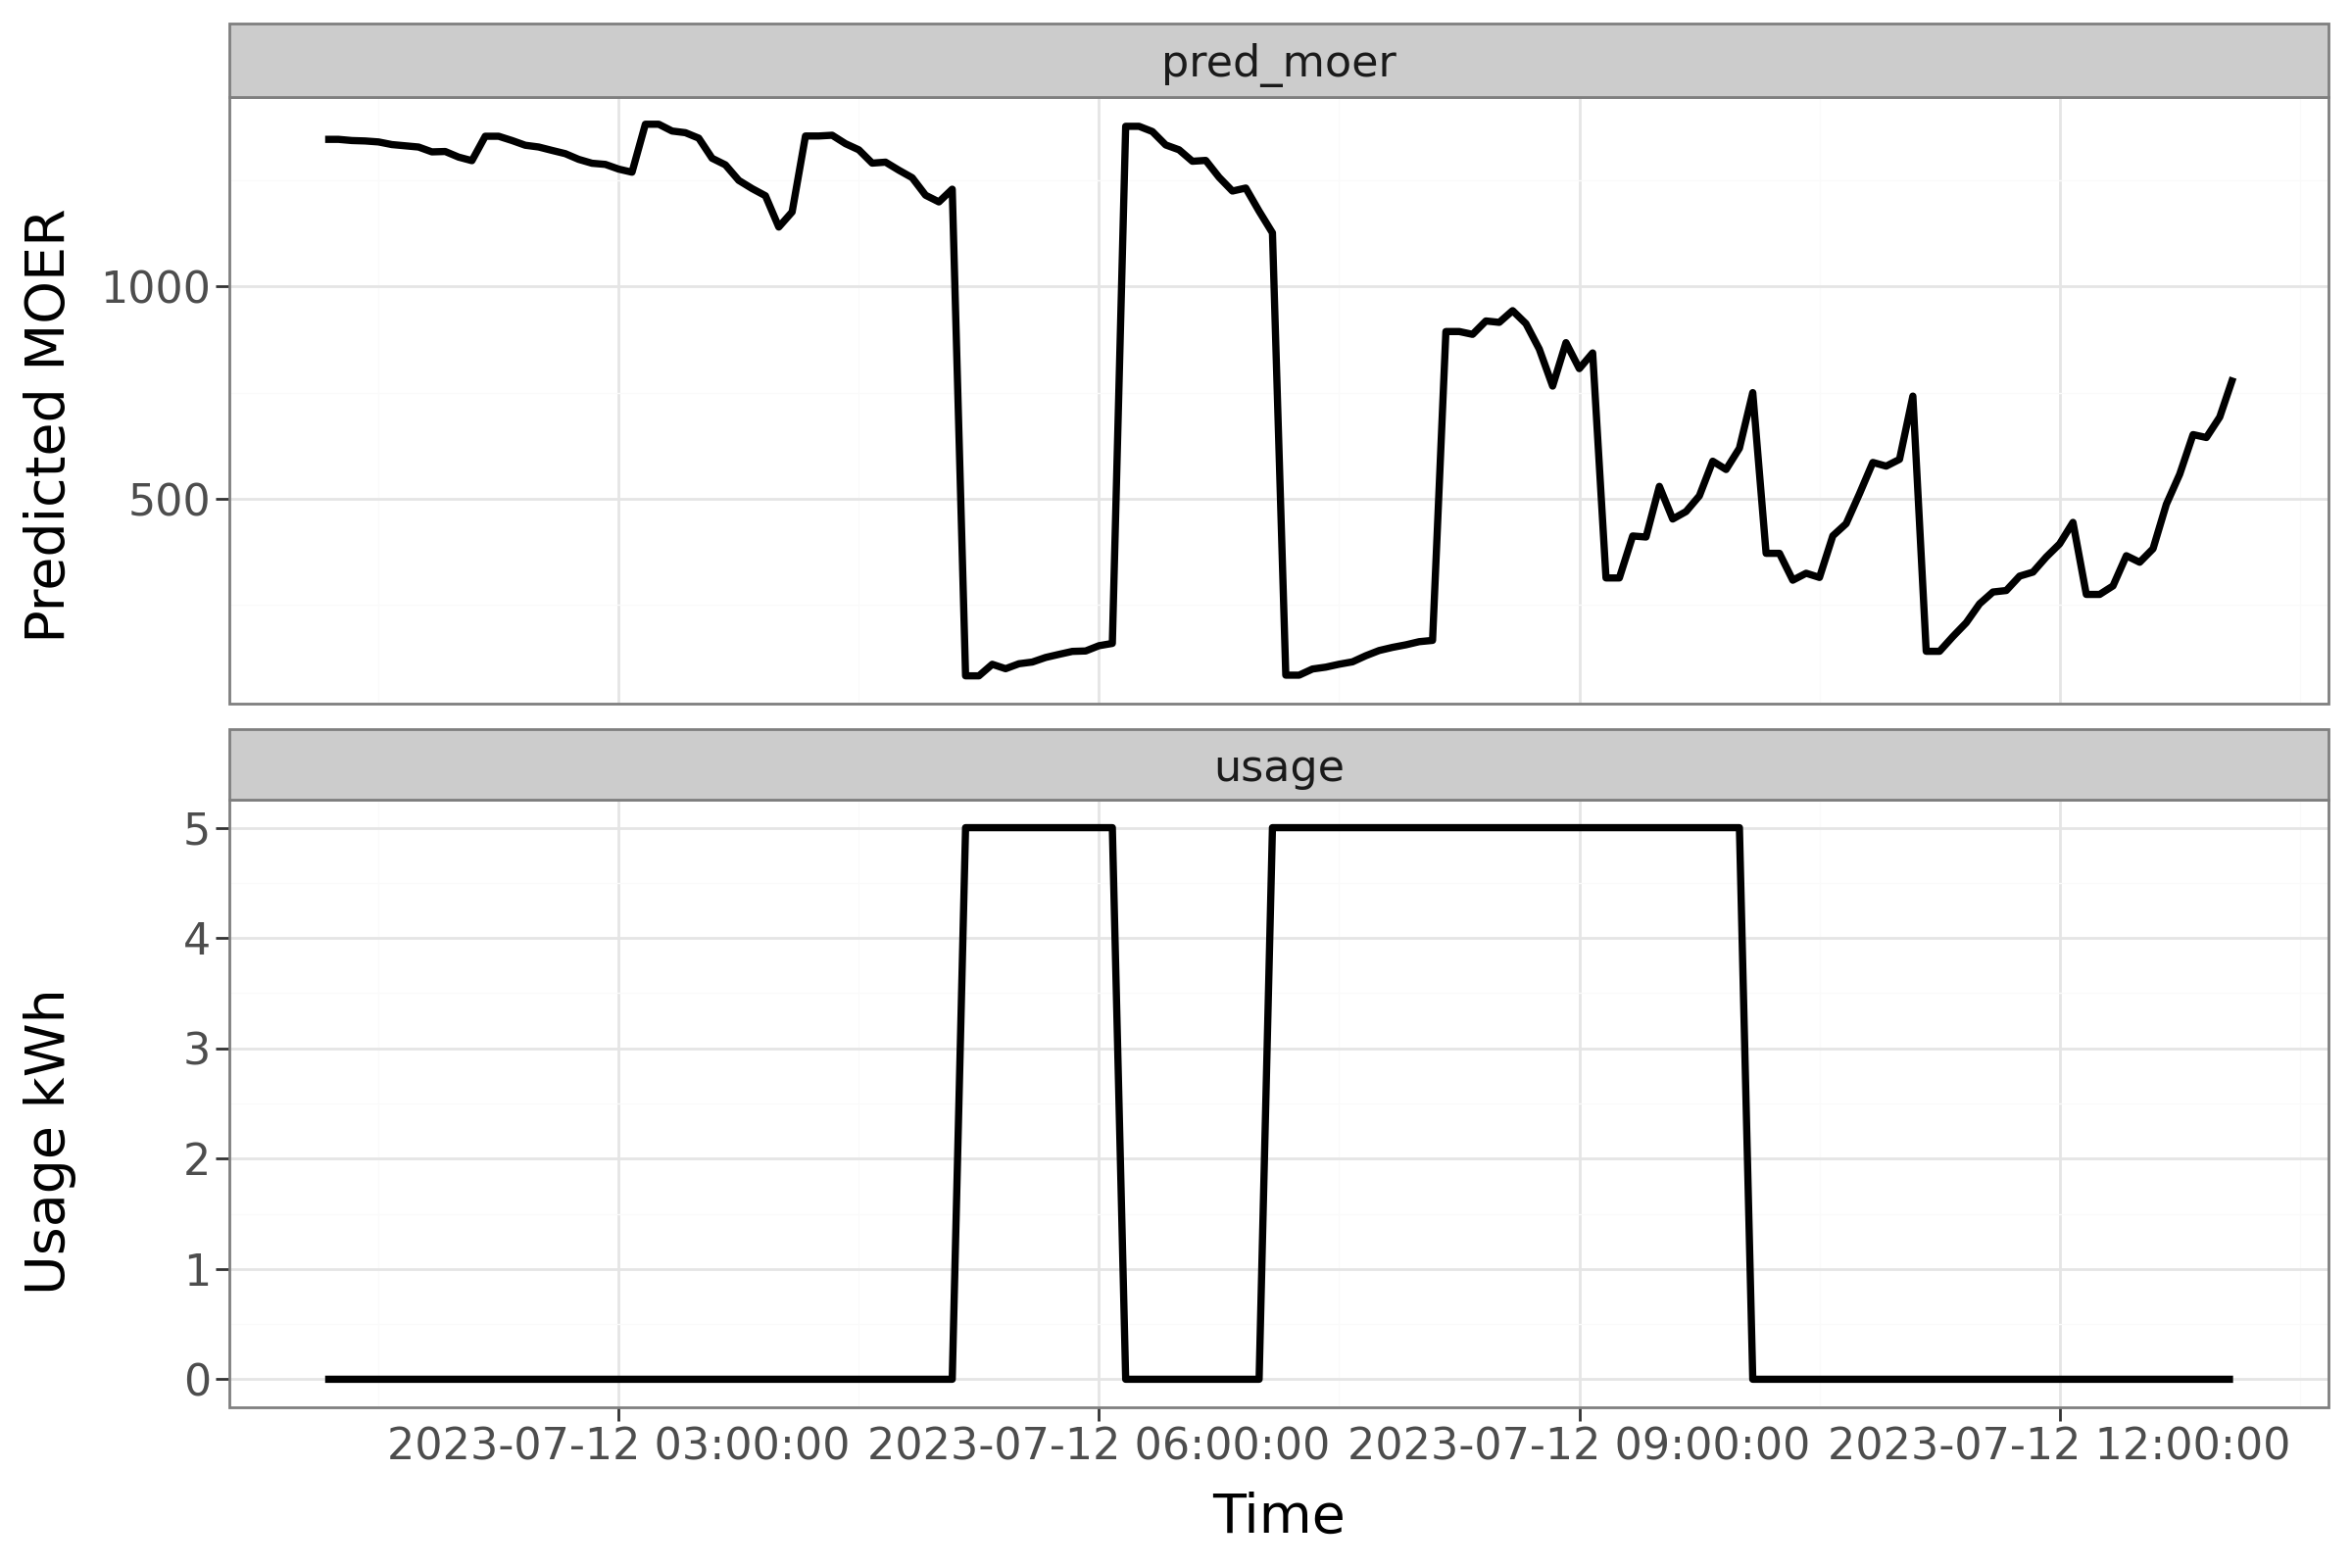

In [40]:
plot_schedule(schedules[11])

In [77]:
all_schedules = pd.concat(schedules)
all_schedules["point_time"] = pd.to_datetime(all_schedules["point_time"])

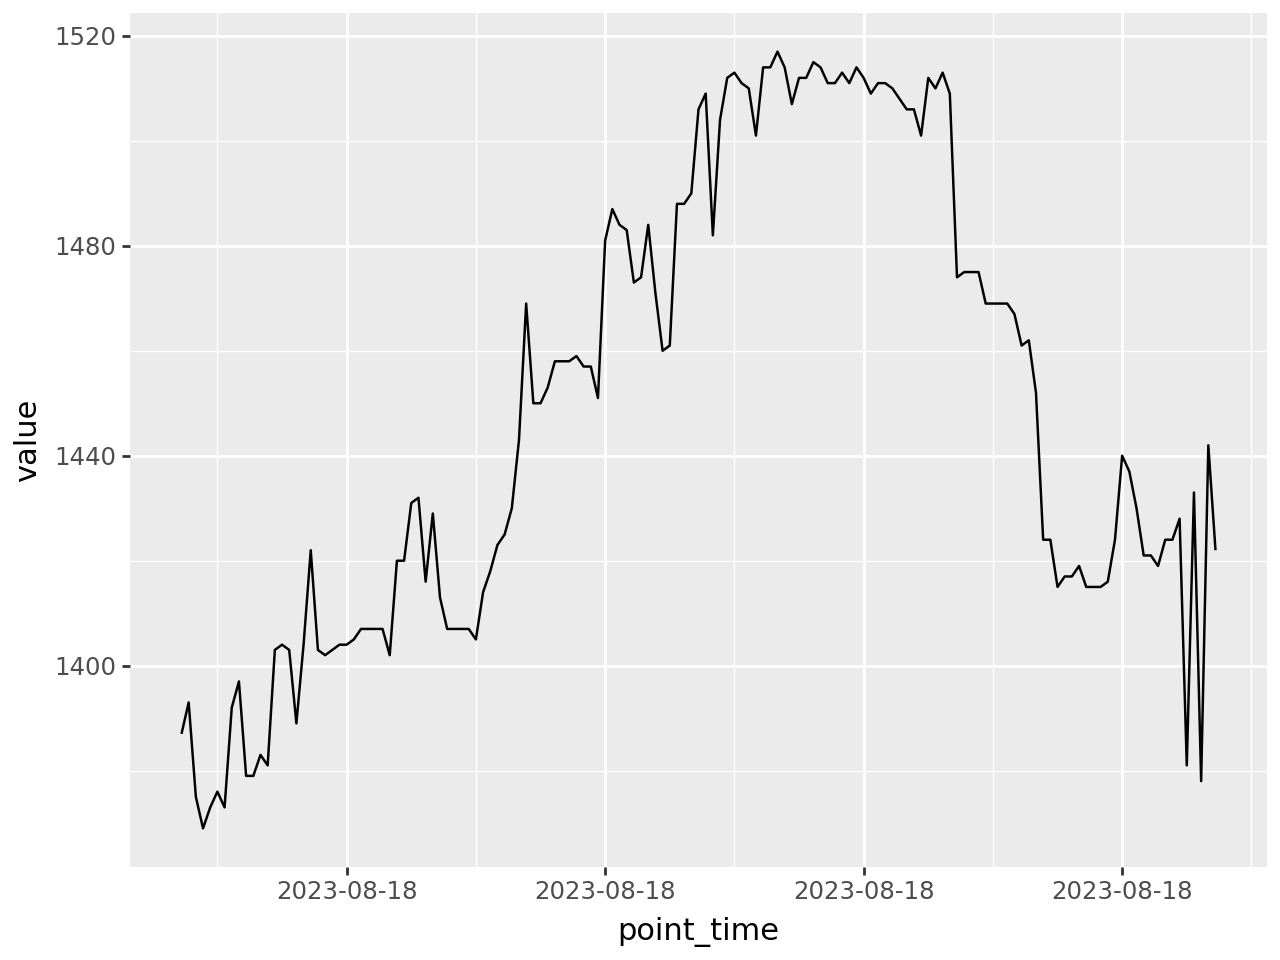

In [78]:
(ggplot(actuals, aes(x = 'point_time', y = "value")) + geom_line())

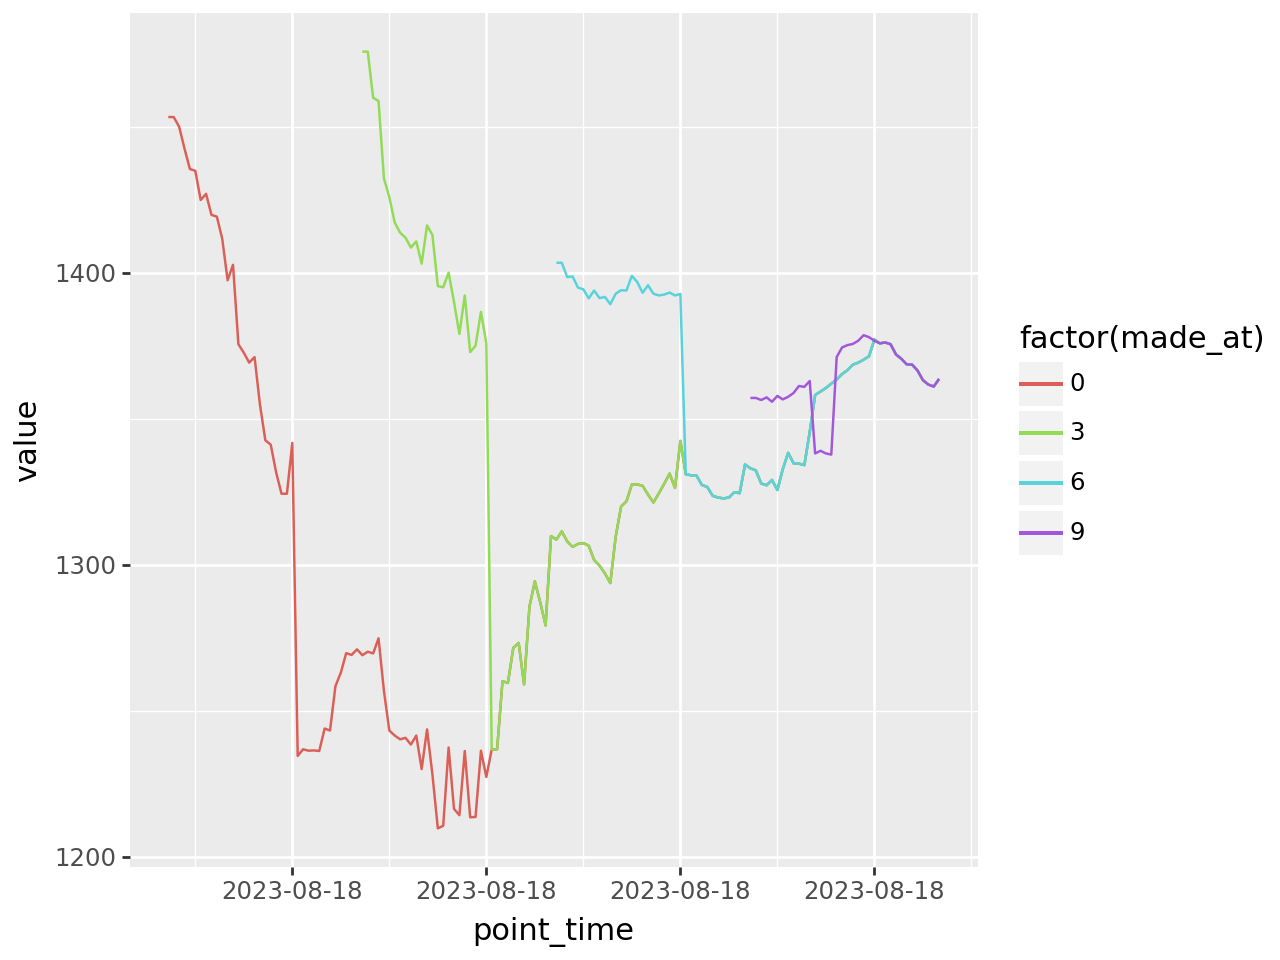

In [80]:
(ggplot(all_forecasts.query("made_at.isin([0, 3, 6, 9])"), aes(x = 'point_time', y = "value", color = "factor(made_at)", group = "factor(made_at)")) + geom_line())

In [ ]:
(ggplot(all_schedules.query("made_at.isin([0])"), aes(x = 'point_time', y = "usage", color = "factor(made_at)", group = "factor(made_at)")) + geom_line())

In [ ]:
all_schedules

In [ ]:
(ggplot(all_schedules.query("made_at.isin([0, 3, 6, 9])"), aes(x = 'point_time', y = "usage", color = "factor(made_at)", group = "factor(made_at)")) + geom_line())

In [ ]:
(ggplot(all_schedules.query("made_at.isin([0, 3, 6, 9])"), aes(x = 'point_time', y = "usage", color = "factor(made_at)", group = "factor(made_at)")) + geom_line())

In [43]:
efu.get_schedule_and_cost_api(usage_power_kw = 2, 
                              time_needed=240,
                              total_time_horizon=12*12,
                              moer_data=actuals,
                              optimization_method="simple")

== Simple fit! ==


,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2023-07-12 01:05:00+00:00,1367.0,0.0,0.0,0.0
2023-07-12 01:10:00+00:00,1388.0,0.0,0.0,0.0
2023-07-12 01:15:00+00:00,1386.0,0.0,0.0,0.0
2023-07-12 01:20:00+00:00,1390.0,0.0,0.0,0.0
2023-07-12 01:25:00+00:00,1390.0,0.0,0.0,0.0
...,...,...,...,...
2023-07-12 12:40:00+00:00,1433.0,0.0,0.0,0.0
2023-07-12 12:45:00+00:00,1437.0,0.0,0.0,0.0
2023-07-12 12:50:00+00:00,1438.0,0.0,0.0,0.0


In [45]:
efu.get_schedule_and_cost_api_requerying(region = "SPP_TX",
                            usage_power_kw = 2, 
                            time_needed=240,
                            start_time=recalculating_optimizer_start_time,
                            end_time=recalculating_optimizer_end_time,
                            optimization_method="simple",
                            requery_interval_minutes = 60)

240
2
== Simple fit! ==
240
2
== Simple fit! ==
240
2
== Simple fit! ==
240
2
== Simple fit! ==
180
2
== Simple fit! ==
175
2
== Simple fit! ==
115
2
== Simple fit! ==
55
2
== Simple fit! ==
0
2
== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


0
2
== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


0
2
== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


0
2
== Simple fit! ==


/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
/home/canyon.foot/watttime-python-client-aer-algo/.venv/lib64/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide


,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2023-07-12 02:10:00+00:00,1354.1,0.0,0.0,0.0
2023-07-12 02:15:00+00:00,1354.1,0.0,0.0,0.0
2023-07-12 02:20:00+00:00,1344.1,0.0,0.0,0.0
2023-07-12 02:25:00+00:00,1332.9,0.0,0.0,0.0
2023-07-12 02:30:00+00:00,1328.8,0.0,0.0,0.0
...,...,...,...,...
2023-07-12 12:45:00+00:00,558.0,0.0,0.0,0.0
2023-07-12 12:50:00+00:00,651.3,0.0,0.0,0.0
2023-07-12 12:55:00+00:00,644.4,0.0,0.0,0.0
